In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


In [2]:
import sys
sys.path.insert(0, '/tf/pollock')

In [59]:
import logging
import os
import random
from collections import Counter
from importlib import reload
import time

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

# import pollock
# from pollock.models.model import PollockDataset, PollockModel, load_from_directory
# import pollock.models.analysis as pollock_analysis

In [4]:
import tensorflow as tf
from tensorflow.keras import layers

tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [5]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12796317770548211118, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11498011099742613018
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5130973604870186834
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_GPU:1"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16212562671940417725
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_GPU:2"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 8528865787231216109
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_GPU:3"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 5924210889688154212
 physical_device_desc: "device: XLA_GPU device", name

In [ ]:
DATA_DIR = '/home/estorrs/data/single_cell_classification'
MODEL_DIR = '/home/estorrs/pollock/models'

In [6]:
DATA_DIR = '/data/single_cell_classification'
MODEL_DIR = '/models'

In [7]:
run_name = 'br'

expression_fp = os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_counts_matrix.tsv')
label_fp = os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_metadata.tsv')

training_image_dir = os.path.join(MODEL_DIR, 'scratch', run_name)
model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Genes'
sep='\t'
cell_type_key = 'cell_type'

n_per_cell_type = 5000
epochs = 5
batch_size = 128

In [8]:
expression_df = pd.read_hdf(expression_fp.replace('.tsv', '.h5'), 'df')
expression_df

Genes,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,AC007325.2,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C
HT062B1_S1PA_AAACCCACACAAATGA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT062B1_S1PA_AAACCCAGTGCTCCGA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT062B1_S1PA_AAACCCATCGGAATTC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
HT062B1_S1PA_AAACGAACAGCTAACT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT062B1_S1PA_AAACGAAGTAGGGAGG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HT110B1_XB3_TTTCATGTCGGCAGTC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT110B1_XB3_TTTCCTCGTGTTACTG-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
HT110B1_XB3_TTTGACTCAGGGTCTC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HT110B1_XB3_TTTGGAGCAAGAGGCT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
label_df = pd.read_csv(
    label_fp,
    sep=sep
    )
label_df

,cell_id,sample_id,cancer_type,tissue_type,organ_type,cell_type,species,method,facs
0,HT062B1_S1PA_AAACCCACACAAATGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD8+ T-cells,Homo sapiens,sc,yes
1,HT062B1_S1PA_AAACCCAGTGCTCCGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Endothelial cells,Homo sapiens,sc,yes
2,HT062B1_S1PA_AAACCCATCGGAATTC-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
3,HT062B1_S1PA_AAACGAACAGCTAACT-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
4,HT062B1_S1PA_AAACGAAGTAGGGAGG-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD4+ T-cells,Homo sapiens,sc,yes
...,...,...,...,...,...,...,...,...,...
49083,HT110B1_XB3_TTTCATGTCGGCAGTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
49084,HT110B1_XB3_TTTCCTCGTGTTACTG-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
49085,HT110B1_XB3_TTTGACTCAGGGTCTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
49086,HT110B1_XB3_TTTGGAGCAAGAGGCT-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Macrophages,Homo sapiens,sc,yes


In [10]:
label_df = label_df.set_index('cell_id')
label_df

,sample_id,cancer_type,tissue_type,organ_type,cell_type,species,method,facs
cell_id,,,,,,,,
HT062B1_S1PA_AAACCCACACAAATGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD8+ T-cells,Homo sapiens,sc,yes
HT062B1_S1PA_AAACCCAGTGCTCCGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Endothelial cells,Homo sapiens,sc,yes
HT062B1_S1PA_AAACCCATCGGAATTC-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT062B1_S1PA_AAACGAACAGCTAACT-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
HT062B1_S1PA_AAACGAAGTAGGGAGG-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD4+ T-cells,Homo sapiens,sc,yes
...,...,...,...,...,...,...,...,...
HT110B1_XB3_TTTCATGTCGGCAGTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
HT110B1_XB3_TTTCCTCGTGTTACTG-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT110B1_XB3_TTTGACTCAGGGTCTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes


In [11]:
label_df = label_df.loc[expression_df.index]
label_df

,sample_id,cancer_type,tissue_type,organ_type,cell_type,species,method,facs
HT062B1_S1PA_AAACCCACACAAATGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD8+ T-cells,Homo sapiens,sc,yes
HT062B1_S1PA_AAACCCAGTGCTCCGA-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Endothelial cells,Homo sapiens,sc,yes
HT062B1_S1PA_AAACCCATCGGAATTC-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT062B1_S1PA_AAACGAACAGCTAACT-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
HT062B1_S1PA_AAACGAAGTAGGGAGG-1,TWCE-HT062B1-S1PAA1A1Z1B1,Breast Cancer,Epithelial,Breast,CD4+ T-cells,Homo sapiens,sc,yes
...,...,...,...,...,...,...,...,...
HT110B1_XB3_TTTCATGTCGGCAGTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,BR_Malignant,Homo sapiens,sc,yes
HT110B1_XB3_TTTCCTCGTGTTACTG-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT110B1_XB3_TTTGACTCAGGGTCTC-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Fibroblasts,Homo sapiens,sc,yes
HT110B1_XB3_TTTGGAGCAAGAGGCT-1,TWCE-HT110B1-XB3,Breast Cancer,Epithelial,Breast,Macrophages,Homo sapiens,sc,yes


In [12]:
adata = anndata.AnnData(X=expression_df.values, obs=label_df)
adata.obs.index = expression_df.index
adata.var.index = expression_df.columns
adata

AnnData object with n_obs × n_vars = 49088 × 33538 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs'

In [13]:
counts = Counter(adata.obs[cell_type_key])
counts.most_common()

[('BR_Malignant', 10137),
 ('Fibroblasts', 8305),
 ('CD4+ T-cells', 8001),
 ('CD8+ T-cells', 7080),
 ('Macrophages', 3585),
 ('B-cells', 3001),
 ('Endothelial cells', 2883),
 ('NK cells', 2053),
 ('Tregs', 1523),
 ('Plasma cells', 1445),
 ('Unknown', 808),
 ('Mast cells', 161),
 ('DC', 106)]

In [14]:
## get rid of unknowns
adata = adata[adata.obs[cell_type_key]!='Unknown']
adata

View of AnnData object with n_obs × n_vars = 48280 × 33538 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs'

Trying to set attribute `.obs` of view, copying.
... storing 'sample_id' as categorical
... storing 'cancer_type' as categorical
... storing 'tissue_type' as categorical
... storing 'organ_type' as categorical
... storing 'cell_type' as categorical
... storing 'species' as categorical
... storing 'method' as categorical
... storing 'facs' as categorical


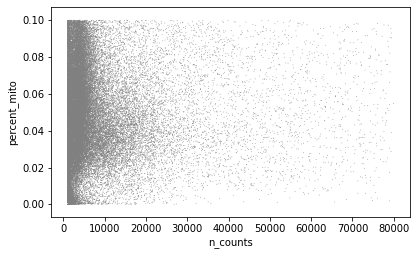

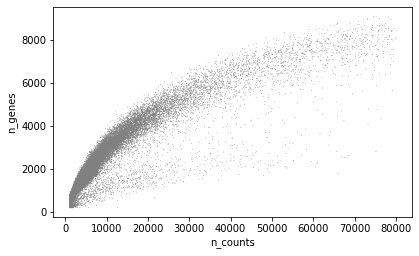

In [16]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [15]:
# adata = adata[adata.obs.n_genes < 6000, :]
# adata = adata[adata.obs.percent_mito < 0.05, :]

In [17]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
adata

AnnData object with n_obs × n_vars = 48280 × 26912 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'
    uns: 'log1p'

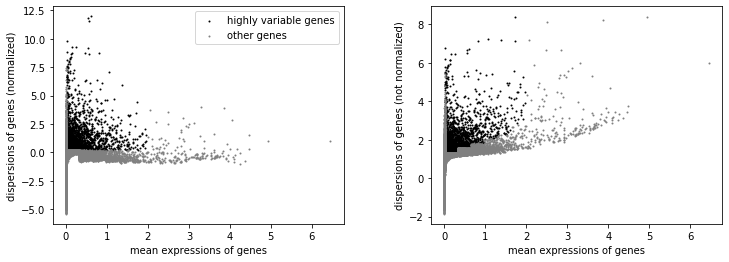

In [18]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=2., min_disp=0.2)
sc.pl.highly_variable_genes(adata)


In [19]:
np.count_nonzero(adata.var.highly_variable)

6020

In [20]:
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
adata

/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_simple.py:909: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 48280 × 6020 
    obs: 'sample_id', 'cancer_type', 'tissue_type', 'organ_type', 'cell_type', 'species', 'method', 'facs', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

In [21]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)

/usr/local/lib/python3.6/dist-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../usr/local/lib/python3.6/dist-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/usr/local/lib/python3.6/dist-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../usr/local/lib/python3.6/dist-packages/umap/utils.py", line 409:
@numba.njit(p

In [22]:
import random
## filter smartly
n = 500

cell_type_to_idxs = {}
for cell_id, cell_type in zip(adata.obs.index, adata.obs[cell_type_key]):
    if cell_type not in cell_type_to_idxs:
        cell_type_to_idxs[cell_type] = [cell_id]
    else:
        cell_type_to_idxs[cell_type].append(cell_id)
        
def temp(ls):
    if len(ls) > n:
        return random.sample(ls, n)
    return random.sample(ls, int(len(ls) * .8))

cell_type_to_idxs = {k:temp(ls)
                     for k, ls in cell_type_to_idxs.items()}

train_idxs = np.asarray([x for ls in cell_type_to_idxs.values() for x in ls])
train_idxs = np.arange(adata.shape[0])[np.isin(np.asarray(adata.obs.index), train_idxs)]
val_idxs = np.delete(np.arange(adata.shape[0]), train_idxs)

train_idxs.shape, val_idxs.shape

((5212,), (43068,))

In [23]:
train_adata = adata[train_idxs, :].copy()
val_adata = adata[val_idxs, :].copy()

In [24]:
Counter(val_adata.obs[cell_type_key]).most_common()

[('BR_Malignant', 9637),
 ('Fibroblasts', 7805),
 ('CD4+ T-cells', 7501),
 ('CD8+ T-cells', 6580),
 ('Macrophages', 3085),
 ('B-cells', 2501),
 ('Endothelial cells', 2383),
 ('NK cells', 1553),
 ('Tregs', 1023),
 ('Plasma cells', 945),
 ('Mast cells', 33),
 ('DC', 22)]

In [25]:
Counter(train_adata.obs[cell_type_key]).most_common()

[('BR_Malignant', 500),
 ('CD8+ T-cells', 500),
 ('Endothelial cells', 500),
 ('Macrophages', 500),
 ('CD4+ T-cells', 500),
 ('Fibroblasts', 500),
 ('Tregs', 500),
 ('NK cells', 500),
 ('Plasma cells', 500),
 ('B-cells', 500),
 ('Mast cells', 128),
 ('DC', 84)]

In [ ]:
## binarize for first pass

In [26]:
train_adata.X

array([[-0.3745462 , -0.12042149, -0.3049892 , ..., -0.16424143,
        -0.29041588, -0.1385985 ],
       [-0.3745462 , -0.12042149, -0.3049892 , ..., -0.16424143,
         5.684939  , -0.1385985 ],
       [-0.05713082, -0.12042149,  1.2627921 , ..., -0.16424143,
        -0.29041588, -0.1385985 ],
       ...,
       [-0.3745462 , -0.12042149, -0.3049892 , ..., -0.16424143,
        -0.29041588, -0.1385985 ],
       [-0.3745462 , -0.12042149, -0.3049892 , ..., -0.16424143,
        -0.29041588, -0.1385985 ],
       [-0.3745462 , -0.12042149, -0.3049892 , ..., -0.16424143,
        -0.29041588, -0.1385985 ]], dtype=float32)

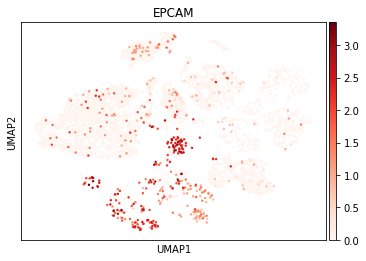

In [28]:
sc.pl.umap(train_adata, color=['EPCAM'], color_map='Reds')

In [42]:
set(train_adata.raw.X[:, train_adata.raw.var.index=='EPCAM'].flatten())

{0.0,
 0.14530881,
 0.16296929,
 0.17725983,
 0.21927217,
 0.22133341,
 0.22502942,
 0.25049806,
 0.26377958,
 0.26436877,
 0.2683364,
 0.26884443,
 0.27267233,
 0.274715,
 0.28254285,
 0.30366215,
 0.3165898,
 0.3177666,
 0.32040548,
 0.3373029,
 0.3381646,
 0.33892444,
 0.33924946,
 0.3448851,
 0.34618747,
 0.3520228,
 0.35772377,
 0.36982918,
 0.37294042,
 0.3773905,
 0.3965197,
 0.39789447,
 0.40174994,
 0.41909796,
 0.42213216,
 0.42444178,
 0.44818753,
 0.44835782,
 0.4538492,
 0.45469242,
 0.4589283,
 0.46002412,
 0.46151513,
 0.46345294,
 0.4694792,
 0.48637477,
 0.48804533,
 0.50339115,
 0.5094693,
 0.5110657,
 0.51237714,
 0.51676196,
 0.51769197,
 0.518259,
 0.519452,
 0.53066325,
 0.5517695,
 0.5578643,
 0.57007706,
 0.5709465,
 0.5828868,
 0.58290434,
 0.59976614,
 0.6050017,
 0.60918176,
 0.6195803,
 0.6214489,
 0.62578684,
 0.6266781,
 0.63092744,
 0.6345282,
 0.6439118,
 0.64558995,
 0.6458921,
 0.64897364,
 0.6673353,
 0.67851114,
 0.6888747,
 0.68892413,
 0.69304717,


In [46]:
# import seaborn as sns
# sns.distplot(train_adata.X[:, train_adata.var.index=='KRT18'].flatten(), kde=False, bins=100)

In [47]:
# sns.distplot(train_adata.raw.X[:, train_adata.raw.var.index=='EPCAM'].flatten(), kde=False, bins=100)

In [49]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [51]:
X_train = np.copy(train_adata.X)
X_val = np.copy(val_adata.X)

scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train.shape, X_val.shape

((5212, 6020), (43068, 6020))

In [54]:
TRAIN_BUF = 1000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(X_val).batch(BATCH_SIZE)

In [124]:
class BVAE(tf.keras.Model):
  def __init__(self, latent_dim, input_size):
    super(BVAE, self).__init__()
    self.latent_dim = latent_dim
    self.input_size = input_size
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(input_size,)),
#           tf.keras.layers.Conv2D(
#               filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
#           tf.keras.layers.Conv2D(
#               filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
#           tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(800, activation='relu'),
          tf.keras.layers.Dropout(.2),
          tf.keras.layers.Dense(input_size),
#           tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
#           tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
#           tf.keras.layers.Conv2DTranspose(
#               filters=64,
#               kernel_size=3,
#               strides=(2, 2),
#               padding="SAME",
#               activation='relu'),
#           tf.keras.layers.Conv2DTranspose(
#               filters=32,
#               kernel_size=3,
#               strides=(2, 2),
#               padding="SAME",
#               activation='relu'),
#           # No activation
#           tf.keras.layers.Conv2DTranspose(
#               filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

In [129]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

# @tf.function
# def compute_loss(model, x):
#   mean, logvar = model.encode(x)
#   z = model.reparameterize(mean, logvar)
#   x_logit = model.decode(z)

# #   cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
# #   logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])

#   logpx_z = tf.metrics.msle(x_logit, x)
#   logpz = log_normal_pdf(z, 0., 0.)
#   logqz_x = log_normal_pdf(z, mean, logvar)

#   return -tf.reduce_mean(logpx_z + ((logpz - logqz_x) * .0005))
# #   return -tf.reduce_mean(logpx_z)



#         def vae_loss(y_true, y_pred):
#             return K.mean(recon_loss(y_true, y_pred) + self.alpha * kl_loss(y_true, y_pred))

#         def kl_loss(y_true, y_pred):
#             return 0.5 * K.sum(K.exp(self.log_var) + K.square(self.mu) - 1. - self.log_var, axis=1)

#         def recon_loss(y_true, y_pred):
#             return 0.5 * K.sum(K.square((y_true - y_pred)), axis=1)

@tf.function
def compute_loss(model, x, alpha=0.00005):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  kl_loss = .5 * tf.reduce_sum(tf.exp(logvar) + tf.square(mean) - 1. - logvar, axis=1)
  reconstruction_loss = .5 * tf.reduce_sum(tf.square((x - x_logit)), axis=1)

  overall_loss = tf.reduce_mean(reconstruction_loss + alpha * kl_loss)
  return overall_loss
#   logpx_z = tf.metrics.msle(x_logit, x)
#   logpz = log_normal_pdf(z, 0., 0.)
#   logqz_x = log_normal_pdf(z, mean, logvar)
    
#   return -tf.reduce_mean(logpx_z + ((logpz - logqz_x) * .0005))
#   return -tf.reduce_mean(logpx_z)

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [126]:
def l1(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

#   cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
#   logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])

  logpx_z = tf.metrics.mse(x_logit, x)
    

#   logpz = log_normal_pdf(z, 0., 0.)
#   logqz_x = log_normal_pdf(z, mean, logvar)

  return -tf.reduce_mean(logpx_z)

def l2(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

#   cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
#   logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])

  logpx_z = tf.metrics.mse(x_logit, x)

  print(tf.reduce_mean(logpx_z))
  logpz = log_normal_pdf(z, 0., 0.)
  print(tf.reduce_mean(logpz))
  logqz_x = log_normal_pdf(z, mean, logvar)
  print(tf.reduce_mean(logqz_x))

  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [127]:
epochs = 100
latent_dim = 100
# num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
# random_vector_for_generation = tf.random.normal(
#     shape=[num_examples_to_generate, latent_dim])
model = BVAE(latent_dim, X_train.shape[1])

In [128]:
# generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
#       print(l1(model, test_x))
#       print(l2(model, test_x))
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
#     display.clear_output(wait=False)
    print(compute_loss(model, next(iter(test_dataset))))
    print(l2(model, next(iter(test_dataset))))
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
#     generate_and_save_images(
#         model, epoch, random_vector_for_generation)

tf.Tensor(-6.0917215, shape=(), dtype=float32)
tf.Tensor(859.8695, shape=(), dtype=float32)
tf.Tensor(-4900.4487, shape=(), dtype=float32)
tf.Tensor(-286.76898, shape=(), dtype=float32)
tf.Tensor(3753.81, shape=(), dtype=float32)
Epoch: 1, Test set ELBO: 6.3669114112854, time elapse for current epoch 2.5737059116363525
tf.Tensor(-34.842697, shape=(), dtype=float32)
tf.Tensor(901158.25, shape=(), dtype=float32)
tf.Tensor(-12387.314, shape=(), dtype=float32)
tf.Tensor(-147.76656, shape=(), dtype=float32)
tf.Tensor(-888918.7, shape=(), dtype=float32)
Epoch: 2, Test set ELBO: 34.71180725097656, time elapse for current epoch 0.31067514419555664
tf.Tensor(-50.83074, shape=(), dtype=float32)
tf.Tensor(11144772.0, shape=(), dtype=float32)
tf.Tensor(-14273.668, shape=(), dtype=float32)
tf.Tensor(-134.95233, shape=(), dtype=float32)
tf.Tensor(-11130633.0, shape=(), dtype=float32)
Epoch: 3, Test set ELBO: 50.70121765136719, time elapse for current epoch 0.31757473945617676
tf.Tensor(-61.98888, sh

KeyboardInterrupt: 